# ETL

In [ ]:
import polars as pl
pl.__version__

'1.20.0'

### Extract

#### Import packages

In [3]:
! cd plugins/polars_geo && uv run maturin develop --release

    Updating crates.io index
  Downloaded async-stream-impl v0.3.6                                      
  Downloaded android_system_properties v0.1.5iB                            
  Downloaded async-stream v0.3.6bytes: 385.6KiB                            
  Downloaded autocfg v1.4.0ning bytes: 664.2KiB                            
  Downloaded atoi v2.0.0maining bytes: 648.2KiB                            
  Downloaded adler2 v2.0.0ining bytes: 1.0MiB                              
  Downloaded async-trait v0.1.83bytes: 1.0MiB                              
  Downloaded addr2line v0.24.2g bytes: 2.0MiB                              
  Downloaded byteorder v1.5.0ng bytes: 2.0MiB                              
  Downloaded atomic-waker v1.1.2bytes: 2.5MiB                              
  Downloaded bytemuck_derive v1.8.1es: 2.5MiB                              
  Downloaded float_next_after v1.0.0s: 2.9MiB                              
  Downloaded approx v0.5.1ining bytes: 2.9MiB              

In [ ]:

get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

: 

In [1]:
import polars as pl
import polars_geo
from plotnine import *

#### Download and extract Citi Bike trips

In [2]:
# It might be needed to install `unzip` first if you're on Linux or macOS.
# Linux:
# sudo apt update && sudo apt install unzip
# macOS:
# brew install unzip
# Windows:
# Download the ZIP file manually and extract it (sorry)

In [10]:
! curl -sO https://s3.amazonaws.com/tripdata/202403-citibike-tripdata.zip
! unzip -o 202403-citibike-tripdata.csv.zip "*.csv" -x "*/*" -d data/citibike/
! rm -f 202403-citibike-tripdata.csv.zip

unzip:  cannot find or open 202403-citibike-tripdata.csv.zip, 202403-citibike-tripdata.csv.zip.zip or 202403-citibike-tripdata.csv.zip.ZIP.


#### Read Citi Bike trips into a Polars DataFrame

In [16]:
! wc -l data/citibike/202403-citibike-tripdata.csv
! head -n 6 data/citibike/202403-citibike-tripdata.csv

wc: data/citibike/202403-citibike-tripdata.csv: No such file or directory
head: cannot open 'data/citibike/202403-citibike-tripdata.csv' for reading: No such file or directory


In [2]:
trips = pl.read_csv(
    ".//data/202403-citibike-tripdata/202403-citibike-tripdata_1.csv",
    try_parse_dates=True,
    schema_overrides={
        "start_station_id": pl.String,
        "end_station_id": pl.String,
    },
).sort("started_at")

trips.height

1000000

In [3]:
print(trips[:, :4])
print(trips[:, 4:8])
print(trips[:, 8:])

shape: (1_000_000, 4)
┌──────────────────┬───────────────┬─────────────────────────┬─────────────────────────┐
│ ride_id          ┆ rideable_type ┆ started_at              ┆ ended_at                │
│ ---              ┆ ---           ┆ ---                     ┆ ---                     │
│ str              ┆ str           ┆ datetime[μs]            ┆ datetime[μs]            │
╞══════════════════╪═══════════════╪═════════════════════════╪═════════════════════════╡
│ 9EC2AD5F3F8C8B57 ┆ classic_bike  ┆ 2024-02-29 00:20:27.570 ┆ 2024-03-01 01:20:22.196 │
│ C76D82D96516BDC2 ┆ classic_bike  ┆ 2024-02-29 07:54:34.223 ┆ 2024-03-01 08:54:12.611 │
│ B4C73C958C65FEA6 ┆ electric_bike ┆ 2024-02-29 08:47:09.664 ┆ 2024-03-01 09:47:02.393 │
│ E23F7822B3D53E2A ┆ classic_bike  ┆ 2024-02-29 09:57:07.150 ┆ 2024-03-01 10:57:00.848 │
│ B0B6437C50C3AB3E ┆ electric_bike ┆ 2024-02-29 10:29:41.981 ┆ 2024-03-01 11:29:21.539 │
│ …                ┆ …             ┆ …                       ┆ …                       │

#### Read in neighborhoods from GeoJSON

In [4]:
! python -m json.tool data/citibike/nyc-neighborhoods.geojson

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "neighborhood": "Allerton",
                "boroughCode": "2",
                "borough": "Bronx",
                "X.id": "http://nyc.pediacities.com/Resource/Neighborhood/Allerton"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -73.84859700000018,
                            40.871670000000115
                        ],
                        [
                            -73.84582253683678,
                            40.870239076236174
                        ],
                        [
                            -73.85455918463374,
                            40.85995383576425
 

In [5]:
neighborhoods = (
    pl.read_json("data/citibike/nyc-neighborhoods.geojson")
    .select("features")
    .explode("features")
    .unnest("features")
    .unnest("properties")
    .select("neighborhood", "borough", "geometry")
    .unnest("geometry")
    .with_columns(polygon=pl.col("coordinates").list.first())
    .select("neighborhood", "borough", "polygon")
    .filter(pl.col("borough") != "Staten Island")
    .sort("neighborhood")
)

neighborhoods

shape: (258, 3)
┌─────────────────┬──────────┬─────────────────────────────────┐
│ neighborhood    ┆ borough  ┆ polygon                         │
│ ---             ┆ ---      ┆ ---                             │
│ str             ┆ str      ┆ list[list[f64]]                 │
╞═════════════════╪══════════╪═════════════════════════════════╡
│ Allerton        ┆ Bronx    ┆ [[-73.848597, 40.87167], [-73.… │
│ Alley Pond Park ┆ Queens   ┆ [[-73.743333, 40.738883], [-73… │
│ Arverne         ┆ Queens   ┆ [[-73.789535, 40.599972], [-73… │
│ Astoria         ┆ Queens   ┆ [[-73.901603, 40.76777], [-73.… │
│ Bath Beach      ┆ Brooklyn ┆ [[-73.99381, 40.60195], [-73.9… │
│ …               ┆ …        ┆ …                               │
│ Williamsburg    ┆ Brooklyn ┆ [[-73.957572, 40.725097], [-73… │
│ Windsor Terrace ┆ Brooklyn ┆ [[-73.980061, 40.660753], [-73… │
│ Woodhaven       ┆ Queens   ┆ [[-73.86233, 40.695962], [-73.… │
│ Woodlawn        ┆ Bronx    ┆ [[-73.859468, 40.900517], [-73… │
│ Woodside        ┆ Queens   ┆ [[-73.900866, 40.757674], [-73… │
└─────────────────┴──────────┴─────────────────────────────────┘

### Visualizing Neighborhoods and Stations

In [6]:
neighborhoods_coords = (
    neighborhoods.with_row_index("id")
    .explode("polygon")
    .with_columns(
        lon=pl.col("polygon").list.first(),
        lat=pl.col("polygon").list.last(),
    )
    .drop("polygon")
)

neighborhoods_coords

shape: (27_569, 5)
┌─────┬──────────────┬─────────┬────────────┬───────────┐
│ id  ┆ neighborhood ┆ borough ┆ lon        ┆ lat       │
│ --- ┆ ---          ┆ ---     ┆ ---        ┆ ---       │
│ u32 ┆ str          ┆ str     ┆ f64        ┆ f64       │
╞═════╪══════════════╪═════════╪════════════╪═══════════╡
│ 0   ┆ Allerton     ┆ Bronx   ┆ -73.848597 ┆ 40.87167  │
│ 0   ┆ Allerton     ┆ Bronx   ┆ -73.845823 ┆ 40.870239 │
│ 0   ┆ Allerton     ┆ Bronx   ┆ -73.854559 ┆ 40.859954 │
│ 0   ┆ Allerton     ┆ Bronx   ┆ -73.854665 ┆ 40.859586 │
│ 0   ┆ Allerton     ┆ Bronx   ┆ -73.856389 ┆ 40.857594 │
│ …   ┆ …            ┆ …       ┆ …          ┆ …         │
│ 257 ┆ Woodside     ┆ Queens  ┆ -73.910618 ┆ 40.755476 │
│ 257 ┆ Woodside     ┆ Queens  ┆ -73.90907  ┆ 40.757565 │
│ 257 ┆ Woodside     ┆ Queens  ┆ -73.907828 ┆ 40.756999 │
│ 257 ┆ Woodside     ┆ Queens  ┆ -73.90737  ┆ 40.756988 │
│ 257 ┆ Woodside     ┆ Queens  ┆ -73.900866 ┆ 40.757674 │
└─────┴──────────────┴─────────┴────────────┴───────────┘

In [7]:
stations = (
    trips.group_by(station=pl.col("start_station_name"))
    .agg(
        lon=pl.col("start_lng").median(),
        lat=pl.col("start_lat").median(),
    )
    .sort("station")
    .drop_nulls()
)
stations

shape: (2_129, 3)
┌──────────────────────────────┬────────────┬───────────┐
│ station                      ┆ lon        ┆ lat       │
│ ---                          ┆ ---        ┆ ---       │
│ str                          ┆ f64        ┆ f64       │
╞══════════════════════════════╪════════════╪═══════════╡
│ 1 Ave & E 110 St             ┆ -73.9383   ┆ 40.792327 │
│ 1 Ave & E 16 St              ┆ -73.981656 ┆ 40.732219 │
│ 1 Ave & E 18 St              ┆ -73.980544 ┆ 40.733812 │
│ 1 Ave & E 30 St              ┆ -73.975361 ┆ 40.741444 │
│ 1 Ave & E 38 St              ┆ -73.971822 ┆ 40.746202 │
│ …                            ┆ …          ┆ …         │
│ Wyckoff Ave & Stanhope St    ┆ -73.917775 ┆ 40.703545 │
│ Wyckoff St & 3 Ave           ┆ -73.982586 ┆ 40.682755 │
│ Wythe Ave & Metropolitan Ave ┆ -73.963198 ┆ 40.716887 │
│ Wythe Ave & N 13 St          ┆ -73.957021 ┆ 40.722767 │
│ Yankee Ferry Terminal        ┆ -74.016756 ┆ 40.687066 │
└──────────────────────────────┴────────────┴───────────┘

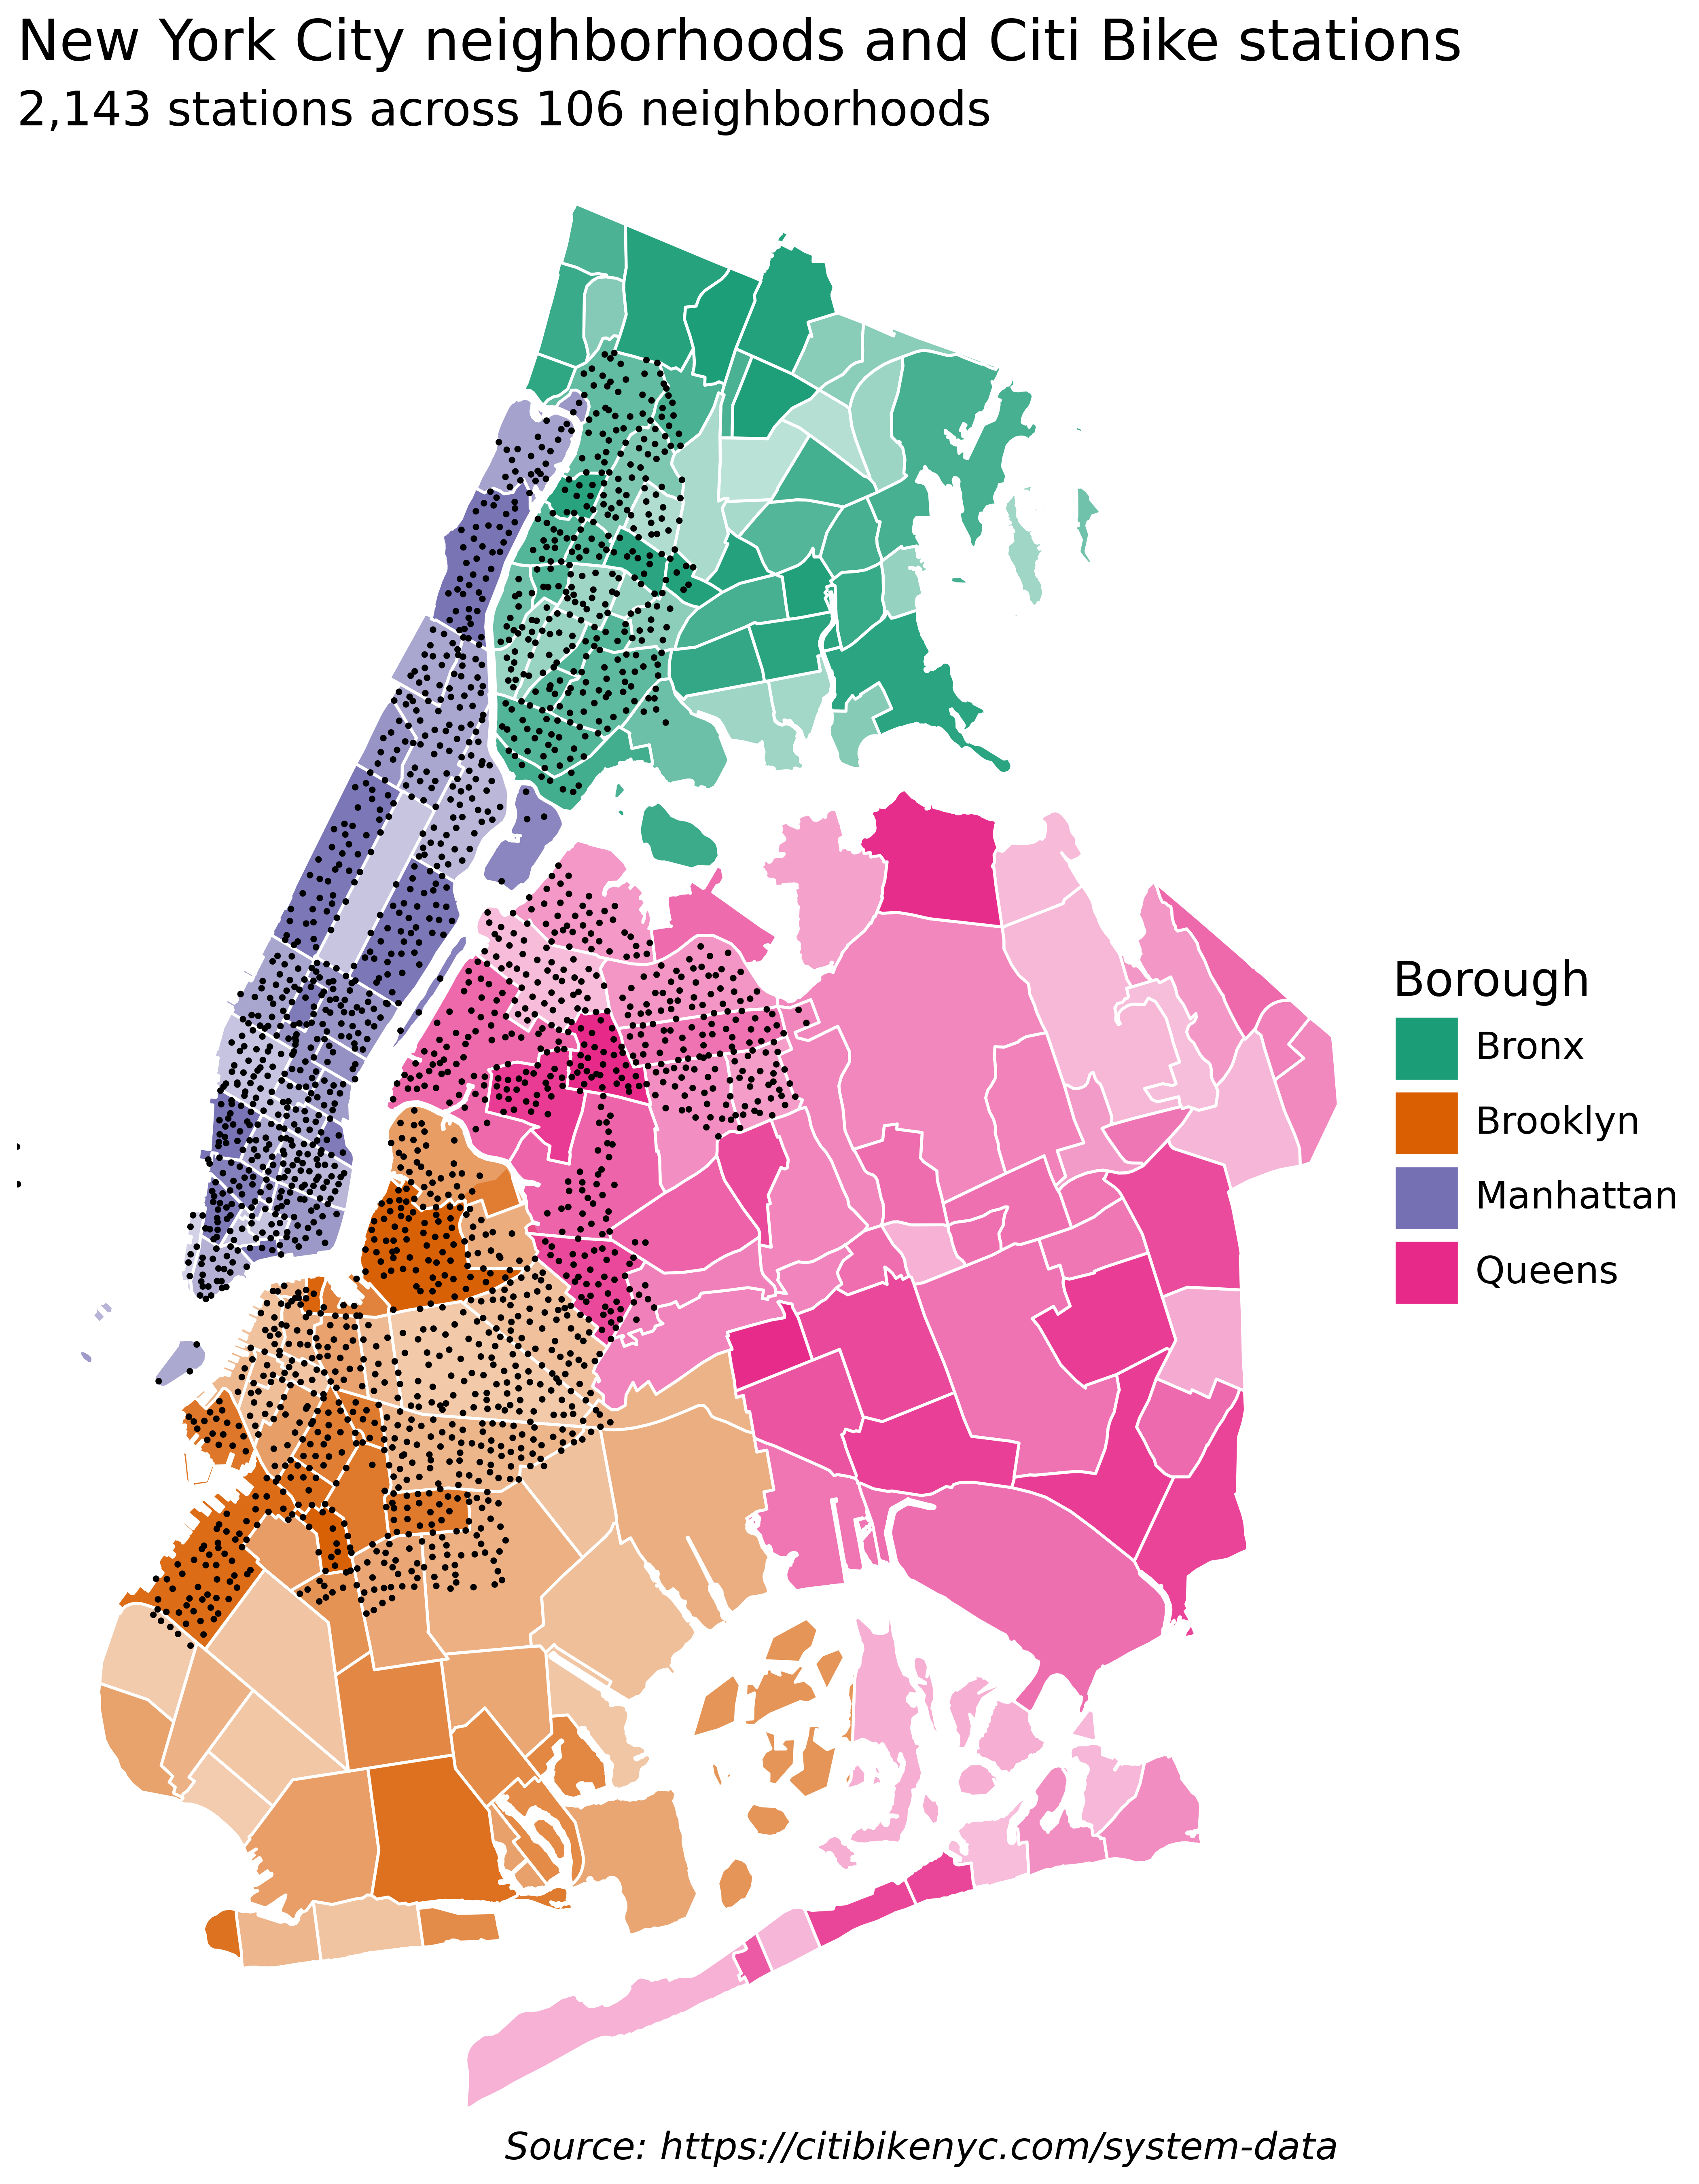

In [8]:
(
    ggplot(neighborhoods_coords, aes(x="lon", y="lat", group="id"))
    + geom_polygon(aes(alpha="neighborhood", fill="borough"), color="white")
    + geom_point(stations, size=0.1)
    + scale_x_continuous(expand=(0, 0))
    + scale_y_continuous(expand=(0, 0, 0, 0.01))
    + scale_alpha_ordinal(range=(0.3, 1))
    + scale_fill_brewer(type="qual", palette=2)
    + guides(alpha=False)
    + labs(
        title="New York City neighborhoods and Citi Bike stations",
        subtitle="2,143 stations across 106 neighborhoods",
        caption="Source: https://citibikenyc.com/system-data",
        fill="Borough",
    )
    + theme_void(base_size=14)
    + theme(
        dpi=300,
        figure_size=(7, 9),
        plot_background=element_rect(fill="white", color="white"),
        plot_caption=element_text(style="italic"),
        plot_margin=0.01,
        plot_title=element_text(ha="left"),
    )
)

### Transform

#### Clean up columns

In [9]:
trips = trips.select(
    bike_type=pl.col("rideable_type")
    .str.split("_")
    .list.get(0)
    .cast(pl.Categorical),
    rider_type=pl.col("member_casual").cast(pl.Categorical),
    datetime_start=pl.col("started_at"),
    datetime_end=pl.col("ended_at"),
    station_start=pl.col("start_station_name"),
    station_end=pl.col("end_station_name"),
    lon_start=pl.col("start_lng"),
    lat_start=pl.col("start_lat"),
    lon_end=pl.col("end_lng"),
    lat_end=pl.col("end_lat"),
).with_columns(
    duration=(pl.col("datetime_end") - pl.col("datetime_start"))
)

trips.columns

['bike_type',
 'rider_type',
 'datetime_start',
 'datetime_end',
 'station_start',
 'station_end',
 'lon_start',
 'lat_start',
 'lon_end',
 'lat_end',
 'duration']

#### Clean up rows

In [10]:
trips = (
    trips.drop_nulls()
    .filter(
        (pl.col("datetime_start") >= pl.date(2024, 3, 1))
        & (pl.col("datetime_end") < pl.date(2024, 4, 1))
    )
    .filter(
        ~(
            (pl.col("station_start") == pl.col("station_end"))
            & (pl.col("duration").dt.total_seconds() < 5 * 60)
        )
    )
)

trips.height

989593

#### Add trip distance

In [11]:
trips = trips.with_columns(
    distance=pl.concat_list("lon_start", "lat_start").geo.haversine_distance(
        pl.concat_list("lon_end", "lat_end")
    )
    / 1000
)

trips.select(
    "lon_start",
    "lon_end",
    "lat_start",
    "lat_end",
    "distance",
    "duration",
)

shape: (989_593, 6)
┌────────────┬────────────┬───────────┬───────────┬──────────┬───────────────┐
│ lon_start  ┆ lon_end    ┆ lat_start ┆ lat_end   ┆ distance ┆ duration      │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---      ┆ ---           │
│ f64        ┆ f64        ┆ f64       ┆ f64       ┆ f64      ┆ duration[μs]  │
╞════════════╪════════════╪═══════════╪═══════════╪══════════╪═══════════════╡
│ -73.995208 ┆ -74.007319 ┆ 40.749653 ┆ 40.707065 ┆ 4.8443   ┆ 27m 36s 805ms │
│ -73.896447 ┆ -73.927311 ┆ 40.816343 ┆ 40.810893 ┆ 2.667176 ┆ 9m 25s 264ms  │
│ -73.988557 ┆ -73.989186 ┆ 40.746201 ┆ 40.742869 ┆ 0.374287 ┆ 3m 29s 483ms  │
│ -73.957462 ┆ -73.979881 ┆ 40.690648 ┆ 40.668663 ┆ 3.090373 ┆ 11m 32s 483ms │
│ -73.933651 ┆ -73.925294 ┆ 40.844044 ┆ 40.818154 ┆ 2.963459 ┆ 18m 27s 973ms │
│ …          ┆ …          ┆ …         ┆ …         ┆ …        ┆ …             │
│ -73.976673 ┆ -73.9634   ┆ 40.785247 ┆ 40.810949 ┆ 3.068644 ┆ 13m 14s 159ms │
│ -73.938787 ┆ -73.949078 ┆ 40.817245 ┆ 40.802557 ┆ 1.84872  ┆ 8m 6s 616ms   │
│ -73.923511 ┆ -73.93114  ┆ 40.69047  ┆ 40.6938   ┆ 0.742174 ┆ 2m 56s 561ms  │
│ -73.994618 ┆ -73.994618 ┆ 40.760094 ┆ 40.760094 ┆ 0.0      ┆ 33m 28s 7ms   │
│ -73.979635 ┆ -73.973747 ┆ 40.752049 ┆ 40.778968 ┆ 3.034034 ┆ 21m 49s 1ms   │
└────────────┴────────────┴───────────┴───────────┴──────────┴───────────────┘

#### Add borough and neighborhood

In [12]:
stations = (
    stations.with_columns(point=pl.concat_list("lon", "lat"))
    .join(neighborhoods, how="cross")
    .with_columns(
        in_neighborhood=pl.col("point").geo.point_in_polygon(pl.col("polygon"))
    )
    .filter(pl.col("in_neighborhood"))
    .unique("station")
    .select(
        "station",
        "borough",
        "neighborhood",
    )
)

stations

shape: (2_127, 3)
┌────────────────────────────┬───────────┬────────────────────┐
│ station                    ┆ borough   ┆ neighborhood       │
│ ---                        ┆ ---       ┆ ---                │
│ str                        ┆ str       ┆ str                │
╞════════════════════════════╪═══════════╪════════════════════╡
│ Walton Ave & E 151 St      ┆ Bronx     ┆ Concourse          │
│ E 13 St & Ave A            ┆ Manhattan ┆ East Village       │
│ MacDonough St & Marcy Ave  ┆ Brooklyn  ┆ Bedford-Stuyvesant │
│ Amsterdam Ave & W 162 St   ┆ Manhattan ┆ Washington Heights │
│ W 233 St & Albany Crescent ┆ Bronx     ┆ Kingsbridge        │
│ …                          ┆ …         ┆ …                  │
│ Somers St & Rockaway Ave   ┆ Brooklyn  ┆ Bedford-Stuyvesant │
│ 30 St & 4 Ave              ┆ Brooklyn  ┆ Sunset Park        │
│ Myrtle Ave & Marcy Ave     ┆ Brooklyn  ┆ Bedford-Stuyvesant │
│ Greenwich Ave & 8 Ave      ┆ Manhattan ┆ West Village       │
│ Edgecombe Ave & W 141 St   ┆ Manhattan ┆ Harlem             │
└────────────────────────────┴───────────┴────────────────────┘

In [13]:
trips = (
    trips.join(
        stations.select(pl.all().name.suffix("_start")), on="station_start"
    )
    .join(stations.select(pl.all().name.suffix("_end")), on="station_end")
    .select(
        "bike_type",
        "rider_type",
        "datetime_start",
        "datetime_end",
        "duration",
        "station_start",
        "station_end",
        "neighborhood_start",
        "neighborhood_end",
        "borough_start",
        "borough_end",
        "lat_start",
        "lon_start",
        "lat_end",
        "lon_end",
        "distance",
    )
)

In [14]:
print(trips[:, :4])
print(trips[:, 4:7])
print(trips[:, 7:11])
print(trips[:, 11:])

shape: (989_506, 4)
┌───────────┬────────────┬─────────────────────────┬─────────────────────────┐
│ bike_type ┆ rider_type ┆ datetime_start          ┆ datetime_end            │
│ ---       ┆ ---        ┆ ---                     ┆ ---                     │
│ cat       ┆ cat        ┆ datetime[μs]            ┆ datetime[μs]            │
╞═══════════╪════════════╪═════════════════════════╪═════════════════════════╡
│ electric  ┆ member     ┆ 2024-03-01 00:00:02.490 ┆ 2024-03-01 00:27:39.295 │
│ electric  ┆ member     ┆ 2024-03-01 00:00:04.120 ┆ 2024-03-01 00:09:29.384 │
│ electric  ┆ casual     ┆ 2024-03-01 00:00:05.209 ┆ 2024-03-01 00:03:34.692 │
│ electric  ┆ member     ┆ 2024-03-01 00:00:09.837 ┆ 2024-03-01 00:11:42.320 │
│ electric  ┆ casual     ┆ 2024-03-01 00:00:13.270 ┆ 2024-03-01 00:18:41.243 │
│ …         ┆ …          ┆ …                       ┆ …                       │
│ classic   ┆ member     ┆ 2024-03-14 19:59:57.027 ┆ 2024-03-14 20:13:11.186 │
│ electric  ┆ member     ┆ 2024-

Visualizing Daily Trips per Borough

In [15]:
trips_per_hour = trips.group_by_dynamic(
    "datetime_start", group_by="borough_start", every="1d"
).agg(num_trips=pl.len())

trips_per_hour

shape: (56, 3)
┌───────────────┬─────────────────────┬───────────┐
│ borough_start ┆ datetime_start      ┆ num_trips │
│ ---           ┆ ---                 ┆ ---       │
│ str           ┆ datetime[μs]        ┆ u32       │
╞═══════════════╪═════════════════════╪═══════════╡
│ Manhattan     ┆ 2024-03-01 00:00:00 ┆ 49216     │
│ Manhattan     ┆ 2024-03-02 00:00:00 ┆ 15359     │
│ Manhattan     ┆ 2024-03-03 00:00:00 ┆ 60282     │
│ Manhattan     ┆ 2024-03-04 00:00:00 ┆ 55495     │
│ Manhattan     ┆ 2024-03-05 00:00:00 ┆ 29068     │
│ …             ┆ …                   ┆ …         │
│ Queens        ┆ 2024-03-10 00:00:00 ┆ 4192      │
│ Queens        ┆ 2024-03-11 00:00:00 ┆ 5008      │
│ Queens        ┆ 2024-03-12 00:00:00 ┆ 6793      │
│ Queens        ┆ 2024-03-13 00:00:00 ┆ 6709      │
│ Queens        ┆ 2024-03-14 00:00:00 ┆ 6223      │
└───────────────┴─────────────────────┴───────────┘

/home/prashant/Desktop/samosa/extra/books/code/python-polars-the-definitive-guide/python-polars-the-definitive-guide-main/.venv/lib/python3.12/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


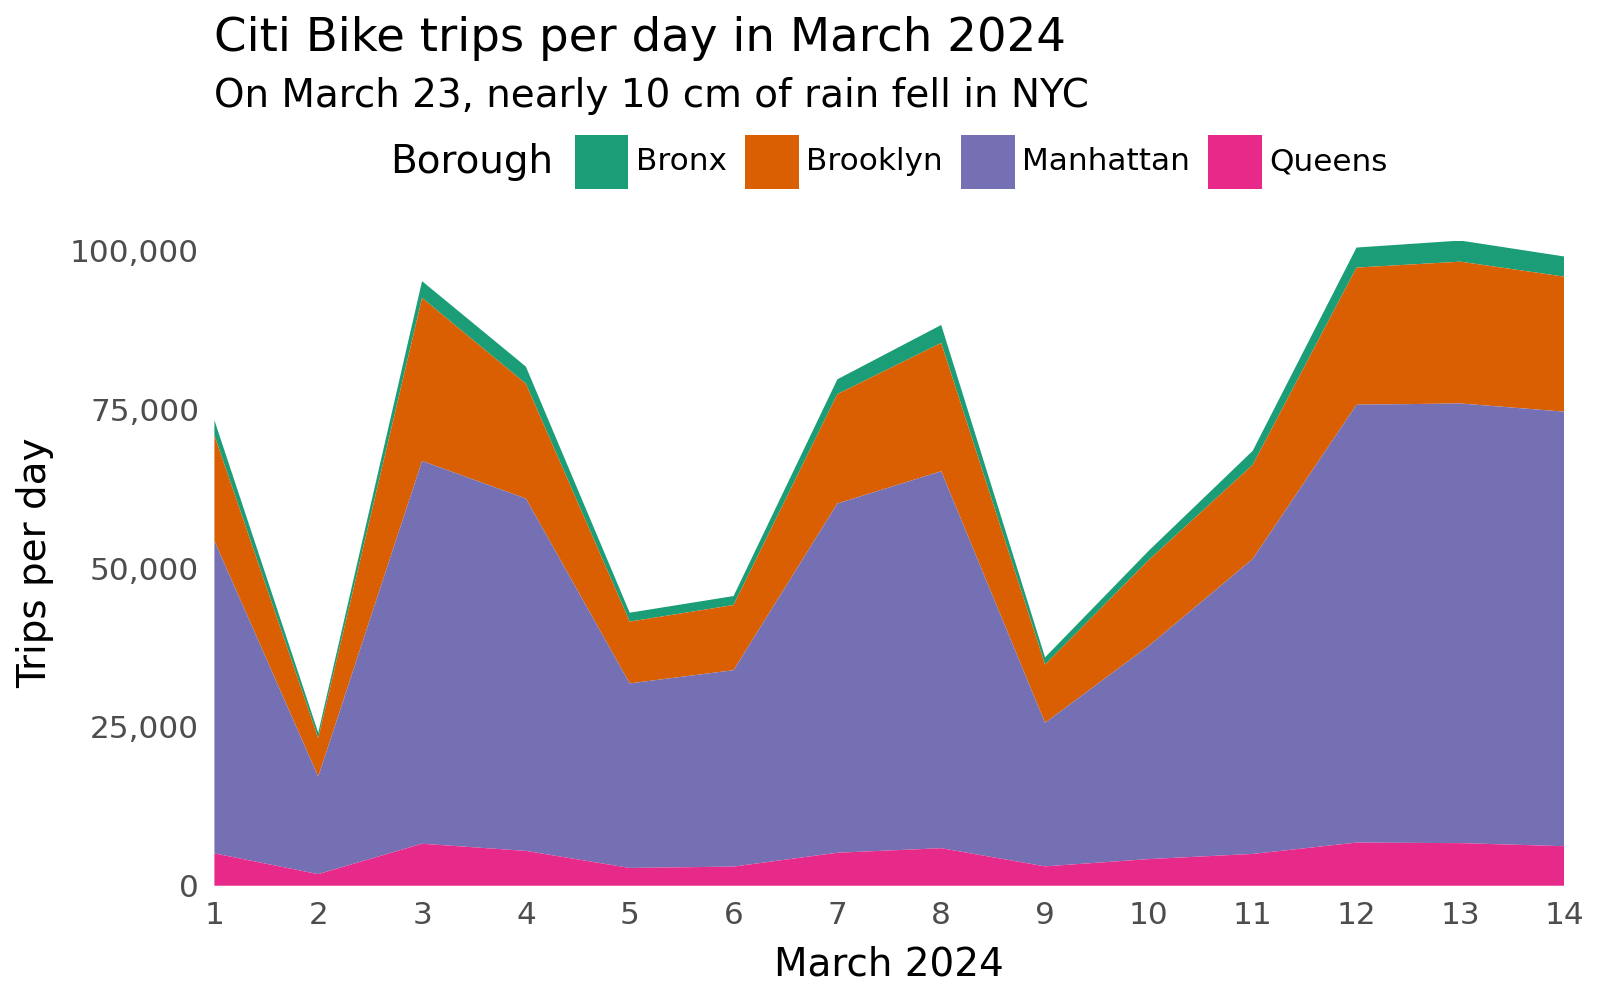

In [16]:
from mizani.labels import label_comma

(
    ggplot(
        trips_per_hour,
        aes(x="datetime_start", y="num_trips", fill="borough_start"),
    )
    + geom_area()
    + scale_fill_brewer(type="qual", palette=2)
    + scale_x_datetime(date_labels="%-d", date_breaks="1 day", expand=(0, 0))
    + scale_y_continuous(labels=label_comma(), expand=(0, 0))
    + labs(
        x="March 2024",
        fill="Borough",
        y="Trips per day",
        title="Citi Bike trips per day in March 2024",
        subtitle="On March 23, nearly 10 cm of rain fell in NYC",
    )
    + theme_tufte(base_size=14)
    + theme(
        axis_ticks_major=element_line(color="white"),
        figure_size=(8, 5),
        legend_position="top",
        plot_background=element_rect(fill="white", color="white"),
        plot_caption=element_text(style="italic"),
        plot_title=element_text(ha="left"),
    )
)

### Load

#### Write partitions

In [17]:
trips_parts = (
    trips.sort("datetime_start")
    .with_columns(date=pl.col("datetime_start").dt.date().cast(pl.String))
    .partition_by(["date"], as_dict=True, include_key=False)
)

for key, df in trips_parts.items():
    df.write_parquet(f"data/citibike/trips-{key[0]}.parquet")

#### Verify

In [18]:
! ls -1 data/citibike/*.parquet

data/citibike/trips-2024-03-01.parquet
data/citibike/trips-2024-03-02.parquet
data/citibike/trips-2024-03-03.parquet
data/citibike/trips-2024-03-04.parquet
data/citibike/trips-2024-03-05.parquet
data/citibike/trips-2024-03-06.parquet
data/citibike/trips-2024-03-07.parquet
data/citibike/trips-2024-03-08.parquet
data/citibike/trips-2024-03-09.parquet
data/citibike/trips-2024-03-10.parquet
data/citibike/trips-2024-03-11.parquet
data/citibike/trips-2024-03-12.parquet
data/citibike/trips-2024-03-13.parquet
data/citibike/trips-2024-03-14.parquet
data/citibike/trips-2024-03-15.parquet
data/citibike/trips-2024-03-16.parquet
data/citibike/trips-2024-03-17.parquet
data/citibike/trips-2024-03-18.parquet
data/citibike/trips-2024-03-19.parquet
data/citibike/trips-2024-03-20.parquet
data/citibike/trips-2024-03-21.parquet
data/citibike/trips-2024-03-22.parquet
data/citibike/trips-2024-03-23.parquet
data/citibike/trips-2024-03-24.parquet
data/citibike/trips-2024-03-25.parquet
data/citibike/trips-2024-

In [19]:
pl.read_parquet("data/citibike/*.parquet").height

/tmp/ipykernel_96267/4213076749.py:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


2465048

### Becoming Faster by Being Lazy

In [24]:
trips = (
    pl.scan_csv(
        ".//data/202403-citibike-tripdata/202403-citibike-tripdata_1.csv",
        try_parse_dates=True,
        schema_overrides={
            "start_station_id": pl.String,
            "end_station_id": pl.String,
        },
    )
    .select(
        bike_type=pl.col("rideable_type").str.split("_").list.get(0),
        rider_type=pl.col("member_casual"),
        datetime_start=pl.col("started_at"),
        datetime_end=pl.col("ended_at"),
        station_start=pl.col("start_station_name"),
        station_end=pl.col("end_station_name"),
        lon_start=pl.col("start_lng"),
        lat_start=pl.col("start_lat"),
        lon_end=pl.col("end_lng"),
        lat_end=pl.col("end_lat"),
    )
    .with_columns(duration=(pl.col("datetime_end") - pl.col("datetime_start")))
    .drop_nulls()
    .filter(
        ~(
            (pl.col("station_start") == pl.col("station_end"))
            & (pl.col("duration").dt.total_seconds() < 5 * 60)
        )
    )
    .with_columns(
        distance=pl.concat_list("lon_start", "lat_start").geo.haversine_distance(
            pl.concat_list("lon_end", "lat_end")
        )
        / 1000
    )
).collect()

neighborhoods = (
    pl.read_json("data/citibike/nyc-neighborhoods.geojson")
    .lazy()
    .select("features")
    .explode("features")
    .unnest("features")
    .unnest("properties")
    .select("neighborhood", "borough", "geometry")
    .unnest("geometry")
    .with_columns(polygon=pl.col("coordinates").list.first())
    .select("neighborhood", "borough", "polygon")
    .sort("neighborhood")
    .filter(pl.col("borough") != "Staten Island")
)

stations = (
    trips.lazy()
    .group_by(station=pl.col("station_start"))
    .agg(
        lat=pl.col("lat_start").median(),
        lon=pl.col("lon_start").median(),
    )
    .with_columns(point=pl.concat_list("lon", "lat"))
    .drop_nulls()
    .join(neighborhoods, how="cross")
    .with_columns(
        in_neighborhood=pl.col("point").geo.point_in_polygon(pl.col("polygon"))
    )
    .filter(pl.col("in_neighborhood"))
    .unique("station")
    .select(
        pl.col("station"),
        pl.col("borough"),
        pl.col("neighborhood"),
    )
).collect()

trips = (
    trips.join(
        stations.select(pl.all().name.suffix("_start")), on="station_start"
    )
    .join(stations.select(pl.all().name.suffix("_end")), on="station_end")
    .select(
        "bike_type",
        "rider_type",
        "datetime_start",
        "datetime_end",
        "duration",
        "station_start",
        "station_end",
        "neighborhood_start",
        "neighborhood_end",
        "borough_start",
        "borough_end",
        "lat_start",
        "lon_start",
        "lat_end",
        "lon_end",
        "distance",
    )
)

trips.height

989683